### The Challenge: Predicting Telecom Customer Churn 

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings('ignore')

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [147]:
path = r'D:\DAU\SEM 1\DS605 - Fundamentals of Machine Learning\Lab\Lab05-DhruvParmar051\data\telecom_churn.csv'

df = pd.read_csv(path)

df.shape

(100000, 10)

In [148]:
df.head()

,CustomerID,Gender,Age,Tenure,PhoneService,InternetService,Streaming,MonthlyCharges,TotalCharges,Churn
0,1,NaN,39.0,6.0,Yes,No,No,20.00,209.33,0
1,2,Female,54.0,14.0,Yes,Fiber optic,Yes,91.96,1241.22,0
2,3,Male,47.0,18.0,NaN,Fiber optic,Yes,86.05,1484.38,0
3,4,Male,30.0,6.0,Yes,DSL,Yes,NaN,NaN,0
4,5,Male,61.0,10.0,Yes,Fiber optic,NaN,90.00,885.41,1


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  int64  
 1   Gender           85076 non-null   object 
 2   Age              85162 non-null   float64
 3   Tenure           85062 non-null   float64
 4   PhoneService     85093 non-null   object 
 5   InternetService  84993 non-null   object 
 6   Streaming        84974 non-null   object 
 7   MonthlyCharges   85013 non-null   float64
 8   TotalCharges     84924 non-null   float64
 9   Churn            100000 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 7.6+ MB


In [150]:
df.describe()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Churn
count,100000.000000,85162.000000,85062.000000,85013.000000,84924.000000,100000.000000
mean,50000.500000,39.705972,11.543027,65.929665,766.710062,0.405770
std,28867.657797,11.629398,11.877483,30.242435,932.767136,0.491043
min,1.000000,18.000000,0.000000,20.000000,0.000000,0.000000
25%,25000.750000,31.000000,3.000000,47.040000,152.710000,0.000000
50%,50000.500000,40.000000,8.000000,62.760000,437.835000,0.000000
75%,75000.250000,48.000000,16.000000,93.330000,1030.300000,1.000000
max,100000.000000,80.000000,72.000000,120.000000,8644.650000,1.000000


In [151]:
df.isna().sum()

CustomerID             0
Gender             14924
Age                14838
Tenure             14938
PhoneService       14907
InternetService    15007
Streaming          15026
MonthlyCharges     14987
TotalCharges       15076
Churn                  0
dtype: int64

### TASK 1: EDA


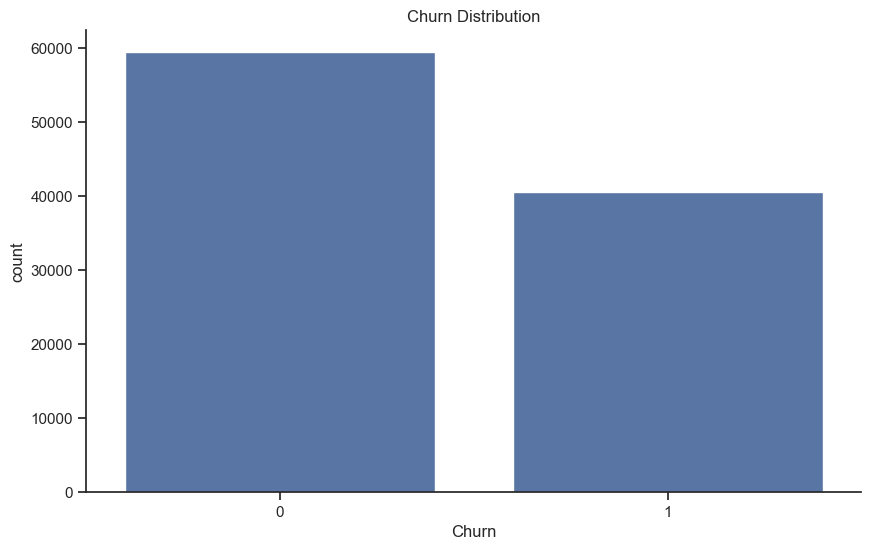

In [152]:
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

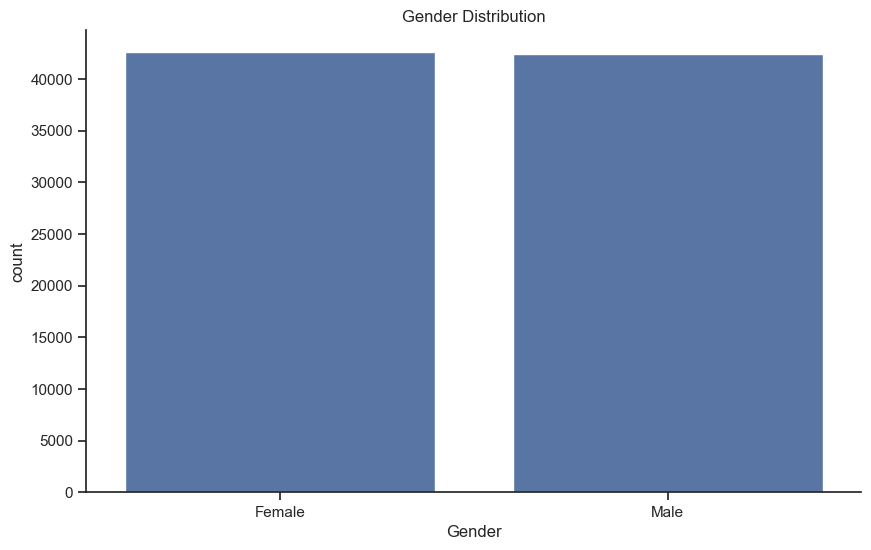

In [153]:
sns.countplot(x='Gender', data=df)
plt.title("Gender Distribution")
plt.show()

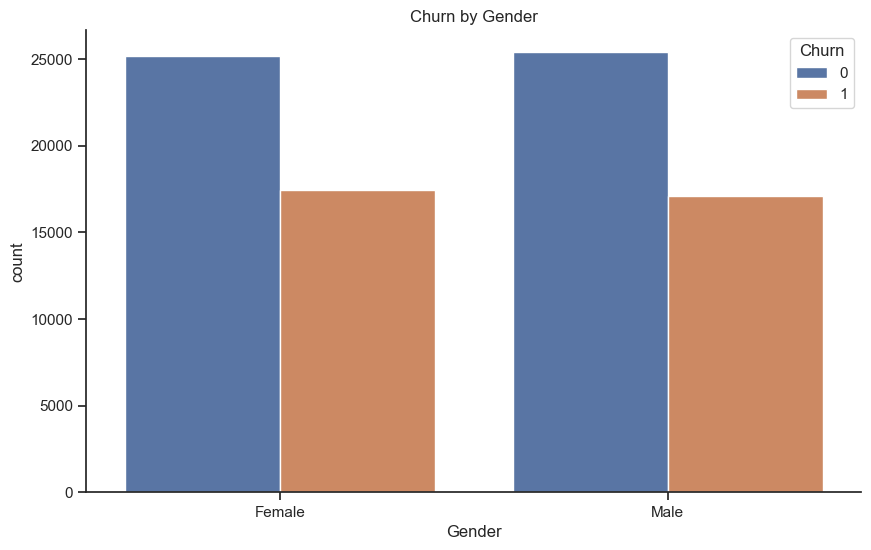

In [154]:
sns.countplot(x='Gender', hue='Churn', data=df)
plt.title("Churn by Gender")
plt.show()

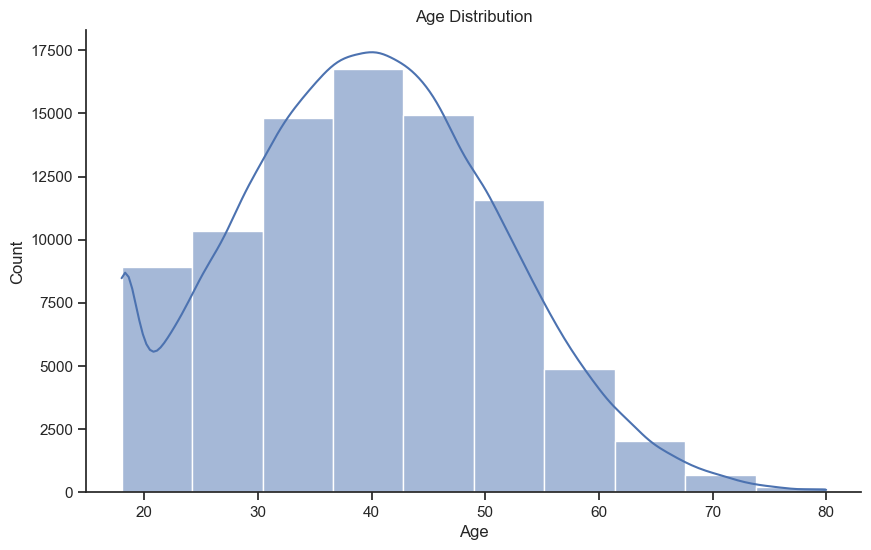

In [155]:
# 4. Age distribution
sns.histplot(df['Age'], bins=10, kde=True)
plt.title("Age Distribution")
plt.show()

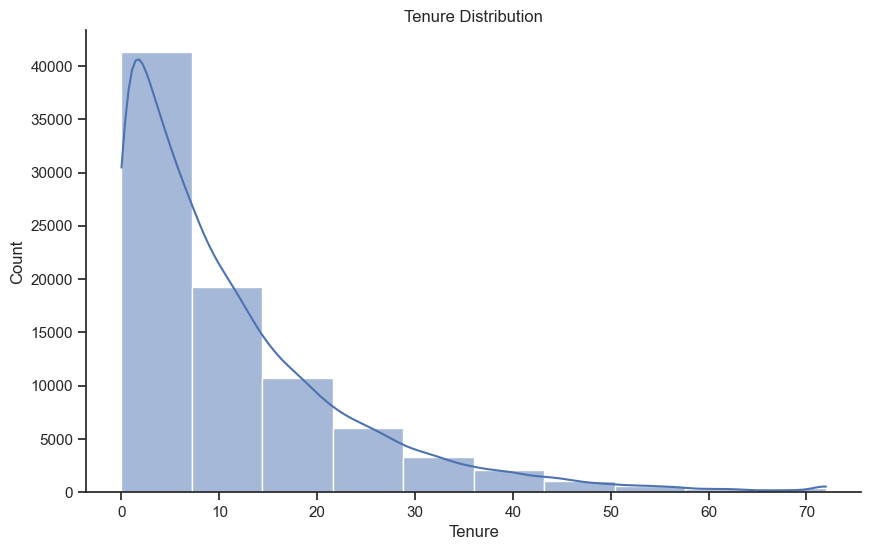

In [156]:
sns.histplot(df['Tenure'], bins=10, kde=True)
plt.title("Tenure Distribution")
plt.show()

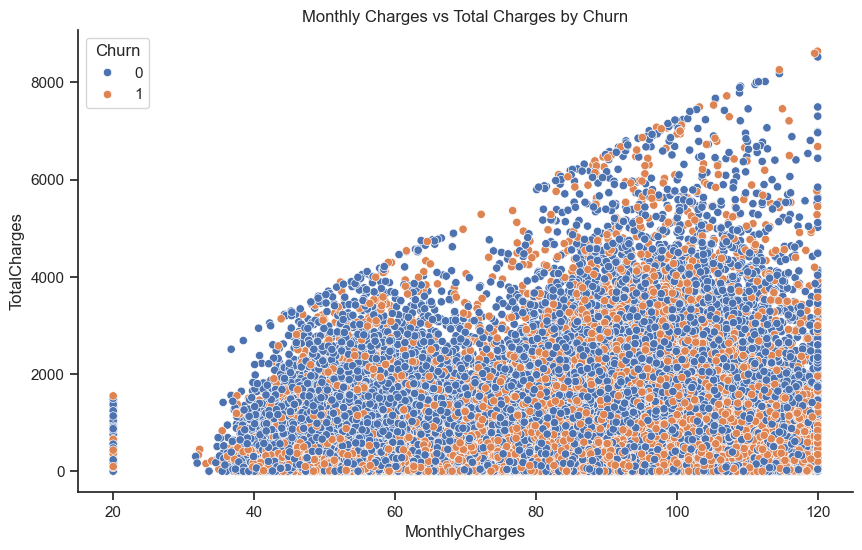

In [157]:
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', hue='Churn', data=df)
plt.title("Monthly Charges vs Total Charges by Churn")
plt.show()


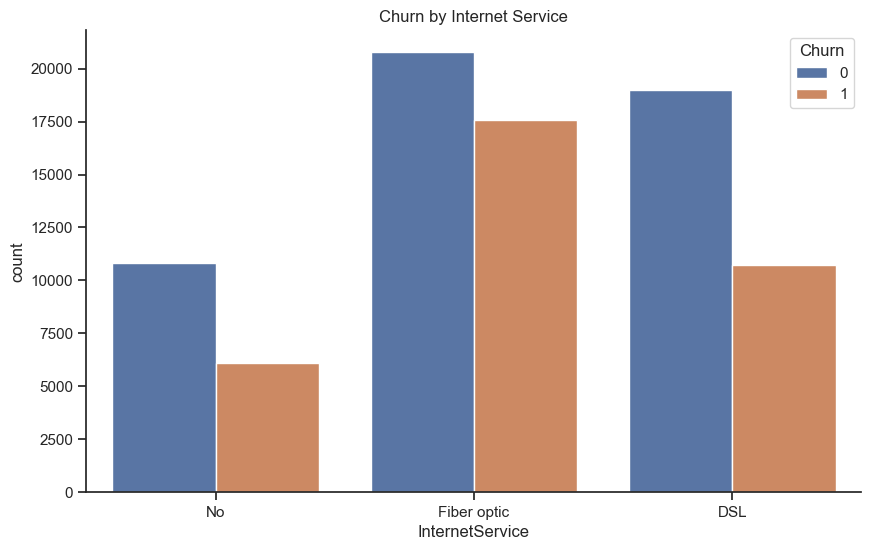

In [158]:
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title("Churn by Internet Service")
plt.show()

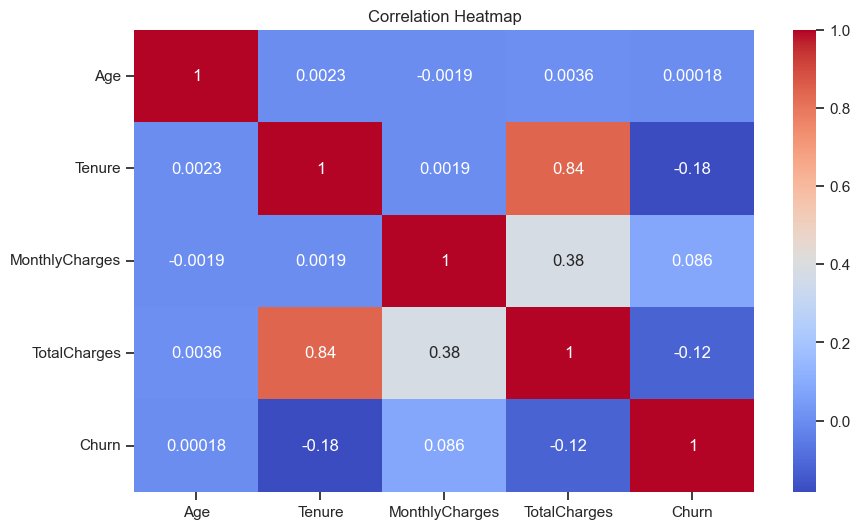

In [159]:
numeric_cols_with_churn = ["Age", "Tenure", "MonthlyCharges", "TotalCharges", "Churn"]
sns.heatmap(df[numeric_cols_with_churn].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

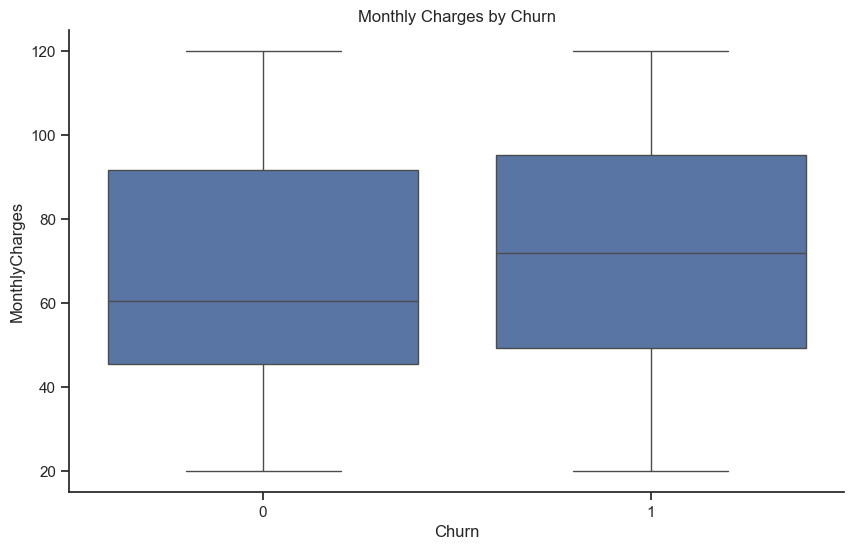

In [160]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()

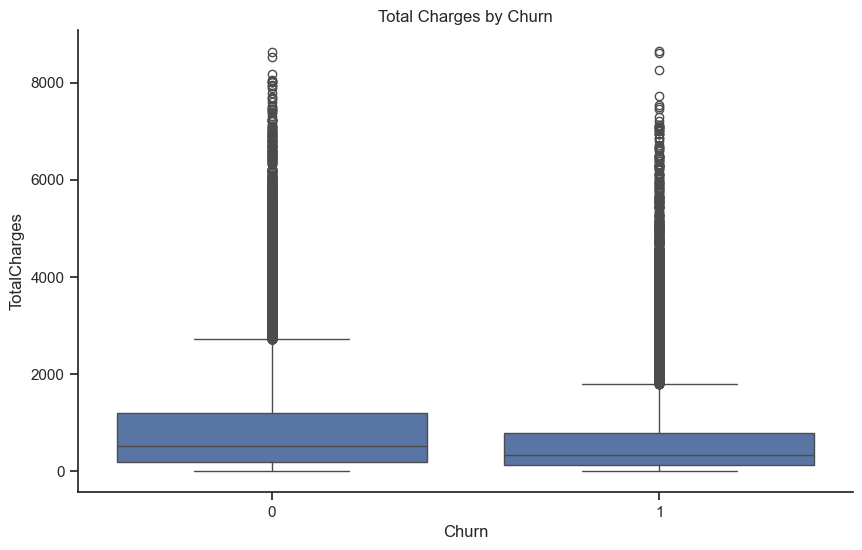

In [161]:
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title("Total Charges by Churn")
plt.show()

#### Remove Outliers

In [162]:
def remove_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 0.5 * IQR
    
    df_filtered = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df_filtered
    
df = remove_outlier(df, "TotalCharges")

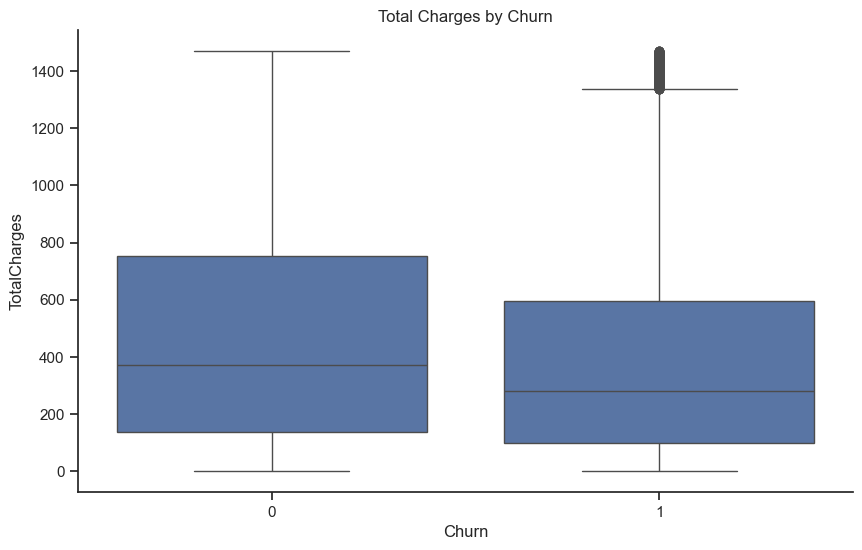

In [163]:
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title("Total Charges by Churn")
plt.show()

#### Summarize the finding in EDA part

- The dataset is imbalanced, with more non-churned customers than churned customers.

- Age and gender distributions are fairly balanced and do not show a strong relationship with churn.

- A large number of customers churn within their first year of service (short tenure).

- Customers with higher monthly charges are more likely to churn.

- However, churned customers have lower total charges due to their short tenure.

- There is a strong positive correlation between tenure and total charges.

- The most significant factor for churn appears to be the type of internet service.

- Customers with Fiber optic internet service have the highest churn rate.

- The relationship between churn and numerical features like Age and Charges is not strongly linear.

- Churn is a bigger problem for new customers and those with specific service types.

### TASK 2:  Feature Engineering

In [164]:
df['SeniorCitizen'] = df['Age'].apply(lambda x: 1 if x >= 65 else 0)

In [165]:
bins = [0, 12, 24, 48, 60, 100]
labels = ['0-12_mo', '13-24_mo', '25-48_mo', '49-60_mo', '>60_mo']
df['Tenure_Group'] = pd.cut(df['Tenure'], bins=bins, labels=labels, right=False)

In [166]:
df['Monthly_Charge_Per_Tenure'] = np.round(df['MonthlyCharges'] / (df['Tenure'] + 0.1),2)

In [167]:
df.head()

,CustomerID,Gender,Age,Tenure,PhoneService,InternetService,Streaming,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Tenure_Group,Monthly_Charge_Per_Tenure
0,1,NaN,39.0,6.0,Yes,No,No,20.00,209.33,0,0,0-12_mo,3.28
1,2,Female,54.0,14.0,Yes,Fiber optic,Yes,91.96,1241.22,0,0,13-24_mo,6.52
4,5,Male,61.0,10.0,Yes,Fiber optic,NaN,90.00,885.41,1,0,0-12_mo,8.91
5,6,Female,21.0,13.0,NaN,Fiber optic,Yes,98.70,1255.55,0,0,13-24_mo,7.53
6,7,NaN,43.0,NaN,Yes,Fiber optic,No,NaN,439.27,0,0,NaN,NaN


### Task 3: Building the End-to-End Pipeline

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def build_pipeline(num_features, cat_features):

    num_pipeline = Pipeline(steps=[
        ('num_impute', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    cat_pipeline = Pipeline(steps=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ('One_hot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])
    
    return preprocessor

In [169]:
y = df['Churn']
X = df.drop('Churn', axis=1)

In [170]:
num_features = X.select_dtypes(include='number').columns.to_list()
cat_features = X.select_dtypes(include='object').columns.to_list()
preprocessor = build_pipeline(num_features, cat_features)

#### Split Data 

In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TASK 4: Model Selection and Hyperparameter Tuning

#### Model Selection

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

''' 
Reason to Choose Models:
1. Logistic Regression:  
   This is an excellent baseline model. It is simple, highly interpretable, and computationally efficient. It's a good choice to start with to get a sense of the problem and establish a benchmark performance.

2. Random Forest Classifier:
   This is a powerful and versatile tree-based ensemble method. It is known for its ability to handle non-linear relationships and its robustness against overfitting. It's a great choice for this type of mixed-feature data and often provides high accuracy without extensive hyperparameter tuning.

3. Gradient Boosting Classifier:
   This is a more advanced ensemble method that typically delivers top-tier performance on structured datasets. By building trees sequentially and correcting the errors of previous trees, it can capture complex patterns in the data. This would be a strong candidate for achieving the best possible accuracy.
'''

cla_models = {
    'Logistic Regression Classifier': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression Classifier': {
        'classifier__C': [0.1, 1.0, 10.0, 100.0],
        'classifier__solver': ['liblinear', 'lbfgs'],
        'classifier__penalty': ['l1', 'l2']
    },
    'Random Forest Classifier': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting Classifier': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 0.9, 1.0]
    }
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


results_clf = {}

for name, model in cla_models.items():
    print(f"\nRunning {name}...")

    # Create pipeline with preprocessor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Prepare param grid for GridSearchCV
    param_grid = param_grids[name]

    # GridSearchCV
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=2,
        scoring='accuracy',
        n_jobs=-1
    )

    # Fit
    grid.fit(X_train, y_train)

    # Predict & evaluate
    y_pred = grid.predict(X_test)
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred)
    }

    # Store results
    results_clf[name] = {
        "best_params": grid.best_params_,
        "metrics": metrics
    }

    print(f"Best Params for {name}: {grid.best_params_}")
    print(f"Metrics: {metrics}")


Running Logistic Regression Classifier...
Best Params for Logistic Regression Classifier: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Metrics: {'accuracy': 0.579766808629477, 'f1_score': 0.3973165114649044, 'precision': 0.5089789635710621, 'recall': 0.32583347019214975}

Running Random Forest Classifier...
